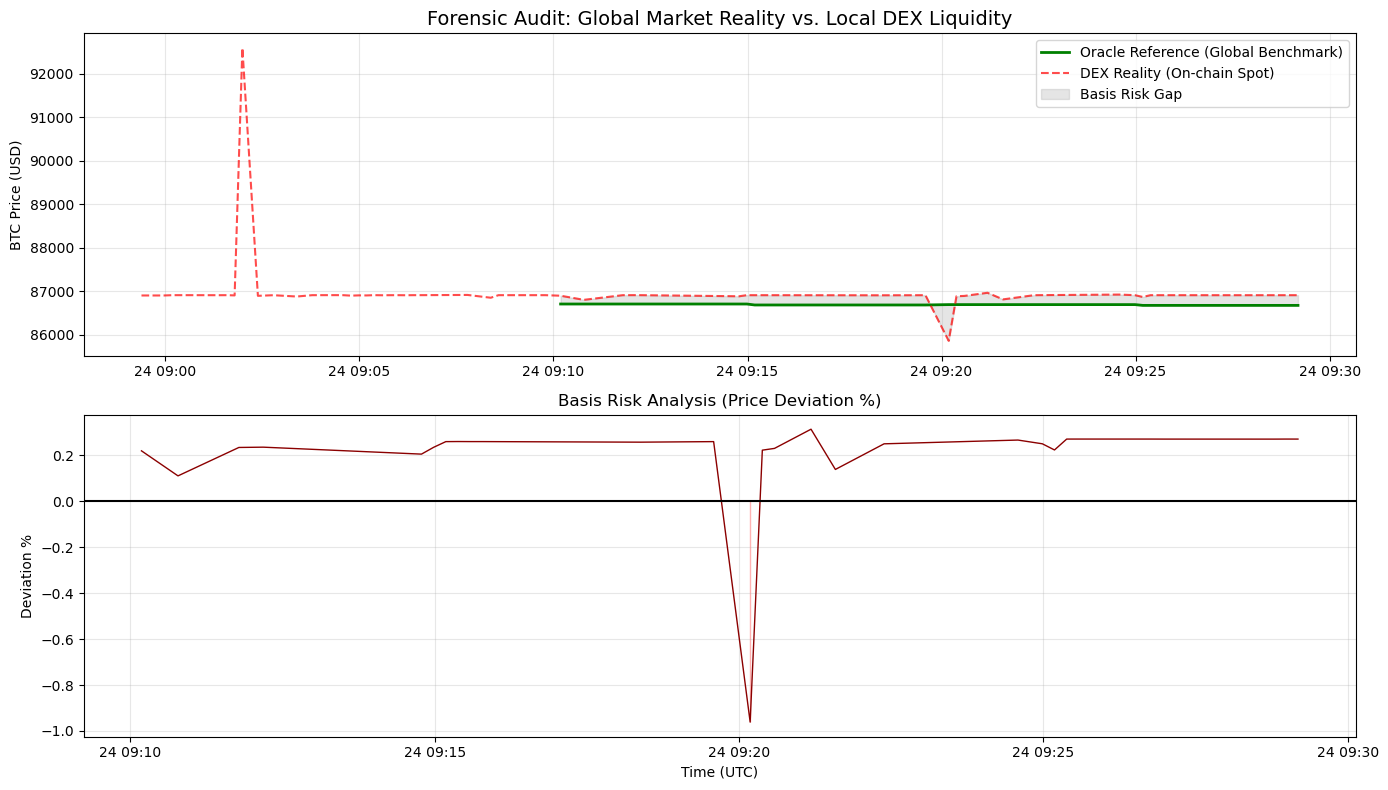

Audit processing complete: Market Reality vs. Basis Risk analysis generated.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Datasets ---
# 09: Global market benchmark prices (representing the Oracle reference)
# 03: On-chain DEX block-level aggregated data (Market Reality)
df_global = pd.read_csv('09_oracle_market_benchmarking.csv')
df_dex = pd.read_csv('03_deviation_audit.csv')

# --- 2. Pre-processing: Time Normalization ---
# Convert global timestamps (Format: 24/12/2025 9:30)
df_global['minute'] = pd.to_datetime(df_global['minute'], dayfirst=True)
df_global_btc = df_global[df_global['symbol'] == 'WBTC'].sort_values('minute')

# Robust timestamp fix for block-level data (Handles ISO or truncated MM:SS.f formats)
def parse_normalized_time(time_str):
    time_str = str(time_str).strip()
    if '2025' in time_str:
        return time_str
    if len(time_str.split(':')) == 2:
        return f"2025-12-24 09:{time_str}"
    elif len(time_str.split(':')) == 3:
        return f"2025-12-24 {time_str}"
    return time_str

# Use the uppercase column name from 03_deviation_audit.csv
df_dex['timestamp_fixed'] = pd.to_datetime(df_dex['BLOCK_TIMESTAMP'].apply(parse_normalized_time))
df_dex = df_dex.dropna(subset=['timestamp_fixed']).sort_values('timestamp_fixed')

# --- 3. Data Alignment: Basis Risk Mapping ---
# Use 'merge_asof' to align DEX blocks with the nearest preceding Global Benchmark minute
df_audit = pd.merge_asof(
    df_dex, 
    df_global_btc[['minute', 'price']], 
    left_on='timestamp_fixed', 
    right_on='minute', 
    direction='backward'
)

# Rename columns for audit clarity
# Map MIN_PRICE to DEX_Spot_Price (The localized crash price)
df_audit.rename(columns={'price': 'Global_Benchmark_Price', 'MIN_PRICE': 'DEX_Spot_Price'}, inplace=True)

# --- 4. Basis Risk Calculation ---
# Basis Risk = (On-chain Spot - Global Index) / Global Index * 100
df_audit['Basis_Risk_Pct'] = (
    (df_audit['DEX_Spot_Price'] - df_audit['Global_Benchmark_Price']) / 
    df_audit['Global_Benchmark_Price'] * 100
)

# --- 5. Visualization: Basis Risk Audit ---
plt.figure(figsize=(14, 8))

# Plot 1: Direct Price Comparison
plt.subplot(2, 1, 1)
plt.plot(df_audit['timestamp_fixed'], df_audit['Global_Benchmark_Price'], 
         label='Oracle Reference (Global Benchmark)', color='green', linewidth=2)
plt.plot(df_audit['timestamp_fixed'], df_audit['DEX_Spot_Price'], 
         label='DEX Reality (On-chain Spot)', color='red', alpha=0.7, linestyle='--')

# Highlight the deviation gap
plt.fill_between(df_audit['timestamp_fixed'], 
                 df_audit['Global_Benchmark_Price'], 
                 df_audit['DEX_Spot_Price'], 
                 color='gray', alpha=0.2, label='Basis Risk Gap')

plt.title('Forensic Audit: Global Market Reality vs. Local DEX Liquidity', fontsize=14)
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Basis Risk Quantization (Deviation %)
plt.subplot(2, 1, 2)
plt.fill_between(df_audit['timestamp_fixed'], df_audit['Basis_Risk_Pct'], 0, 
                 where=(df_audit['Basis_Risk_Pct'] < 0), color='red', alpha=0.3)
plt.plot(df_audit['timestamp_fixed'], df_audit['Basis_Risk_Pct'], color='darkred', linewidth=1)

plt.axhline(y=0, color='black', linestyle='-')
plt.title('Basis Risk Analysis (Price Deviation %)')
plt.ylabel('Deviation %')
plt.xlabel('Time (UTC)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('market_reality_basis_risk.png')
plt.show()

# --- 6. Export Final Audit Evidence ---
# Note: Column 'BLOCK_NUMBER' is used as the audit key
df_audit[['BLOCK_NUMBER', 'timestamp_fixed', 'DEX_Spot_Price', 'Global_Benchmark_Price', 'Basis_Risk_Pct']].to_csv('Market_Forensic_Evidence.csv', index=False)

print("Audit processing complete: Market Reality vs. Basis Risk analysis generated.")